In [12]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import json

In [13]:
# Connect to DB and create an engine instance
with open("../dags/ops/config/config.json", "r") as config:
    print('Reading config file')
    configuration = json.loads(config.read())
alchemyEngine = create_engine(f'postgresql+psycopg2://{configuration["db_connection"]["user"]}:{configuration["db_connection"]["password"]}@{configuration["db_connection"]["host"]}:{configuration["db_connection"]["port"]}/{configuration["db_connection"]["database"]}',
                                 pool_recycle=3600)

dbConnection = alchemyEngine.connect()
# Select all the data from the customers
df = pd.read_sql('select * from customer', dbConnection)
print(df.head())
dbConnection.close()

Reading config file
   customer_id  customer_name  type_customer_id  gender_id  marital_status_id  \
0         1684     Customer 1                 4          3                  3   
1         1685    Customer 10                 3          3                  4   
2         1686   Customer 100                 3          3                  3   
3         1687  Customer 1000                 3          3                  3   
4         1688  Customer 1001                 4          4                  4   

   age  spending_score created_dt modified_dt effective_dt  
0   19              39 2021-11-08        None         None  
1   30              72 2021-11-08        None         None  
2   20              49 2021-11-08        None         None  
3   27               7 2021-11-08        None         None  
4   63              14 2021-11-08        None         None  


In [14]:
# Split dataset into training and set
df = df.loc[:,["customer_id","age","spending_score"]]
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.25,random_state=100)

#Standarize columns for train and test
train[["age_scaled","spending_score_scaled"]] = StandardScaler().fit_transform(train[["age","spending_score"]])
test[["age_scaled","spending_score_scaled"]] = StandardScaler().fit_transform(test[["age","spending_score"]])
train_scaled = train.loc[:,["age_scaled","spending_score_scaled"]]
test_scaled = test.loc[:,["age_scaled","spending_score_scaled"]]
# #df = df.values

In [15]:
# See if there's a correlation between variables
corr = train_scaled.corr()
corr.style.background_gradient(cmap='coolwarm')


,age_scaled,spending_score_scaled
age_scaled,1.000000,-0.035122
spending_score_scaled,-0.035122,1.000000


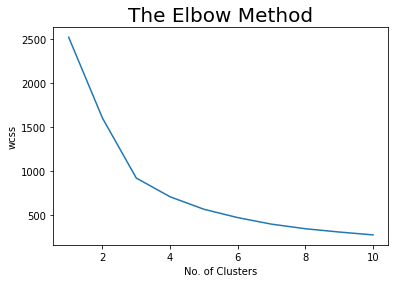

In [16]:
# Use the Elbow Method to determine the number of clusters
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(train_scaled.values)
    wcss.append(km.inertia_)
# Plot the results    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

No handles with labels found to put in legend.


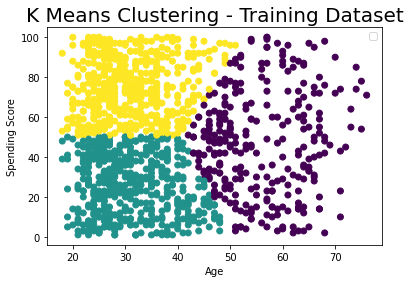

[2 2 1 2 0 2 0 2 2 0]
25 98 2
26 75 2
24 42 1
36 59 2
57 66 0
39 98 2
53 46 0
28 70 2
19 77 2
70 72 0
42 13 1
Cluster Classification
 Cluster 2 = High purchasing activity and Young = Interest Group
 Cluster 1 = Low purchasing activity and Young = Not for Marketing Campaing
 Cluster 0 = Fluctuating purchasing activity and Elder = Not for Marketing Campaing


In [38]:
# Visualize clusters for training dataset
from matplotlib.lines import Line2D
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
train["cluster"] = km.fit_predict(train_scaled.values)

# Test Data 
plt.title('K Means Clustering - Training Dataset', fontsize = 20)
x = train["age"].values
y = train["spending_score"].values
colors = train["cluster"].values
plt.scatter(x, y, c=colors, alpha=1)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.legend()
plt.show()
# See results
print(colors[0:10])
for i in range(0,11):
    print(f"{x[i]} {y[i]} {colors[i]}")
print("Cluster Classification")
print(f" Cluster 2 = High purchasing activity and Young = Interest Group")
print(f" Cluster 1 = Low purchasing activity and Young = Not for Marketing Campaing")
print(f" Cluster 0 = Fluctuating purchasing activity and Elder = Not for Marketing Campaing")



No handles with labels found to put in legend.


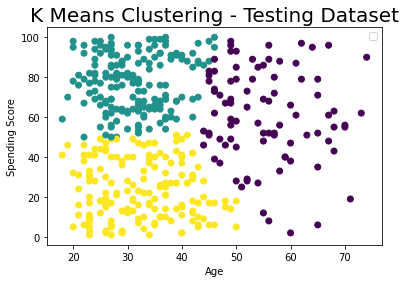

[0 2 2 0 0 2 0 2 1 2]
46 73 0
35 40 2
36 26 2
47 37 0
45 83 0
41 51 2
56 96 0
21 16 2
43 87 1
23 3 2
23 31 2


In [35]:
# Test Data 
# Visualize clusters for testing dataset
test["cluster"] = km.fit_predict(test_scaled.values)

# Test Data 
plt.title('K Means Clustering - Testing Dataset', fontsize = 20)
x = test["age"].values
y = test["spending_score"].values
colors = test["cluster"].values
plt.scatter(x, y, c=colors, alpha=1)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

print(colors[0:10])
for i in range(0,11):
    print(f"{x[i]} {y[i]} {colors[i]}")

In [31]:
# Save the model
import pickle

with open('knn','wb') as file:
    pickle.dump(km,file)

In [32]:
# Print some information about the features for each cluster
print(train.groupby(['cluster'], as_index=False).agg({'age':np.average,'spending_score':np.average}))
print(test.groupby(['cluster'], as_index=False).agg({'age':np.average,'spending_score':np.average}))

   cluster        age  spending_score
0        0  55.850694       46.982639
1        1  31.405622       25.801205
2        2  31.216387       75.308824
   cluster        age  spending_score
0        0  55.235955       60.932584
1        1  31.235294       77.205882
2        2  32.623457       23.691358


In [33]:
# ================== Prediction =====================
import pickle
# Load the model to make predictions
with open('knn','rb') as file:
    km = pickle.load(file)
    print('model loaded')

# Step 1. Input data (sample data)
data = {'age':  [18,20,35],
        'spending_score': [15,80,50]
        }
prediction = pd.DataFrame(data)
# Step2 . Scale features
prediction[["age_scaled","spending_score_scaled"]] = StandardScaler().fit_transform(prediction[["age","spending_score"]])
prediction_scaled = prediction.loc[:,["age_scaled","spending_score_scaled"]]
# Step 3. Fit the model and predict cluster
y_means = km.fit_predict(prediction_scaled)
prediction["cluster"] = y_means
# Step 4. Visualize the model
prediction.head()


model loaded


,age,spending_score,age_scaled,spending_score_scaled,cluster
0,18,15,-0.834812,-1.254912,0
1,20,80,-0.571187,1.192166,2
2,35,50,1.405999,0.062746,1


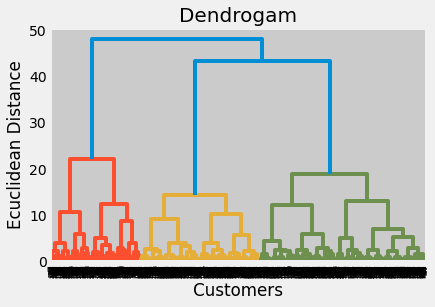

In [48]:
# Second appraoch. Use Hierarchical Cluster
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(df_scaled, method='ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

In [83]:
import pickle
# Save the model
with open('dendrogram','wb') as file:
    pickle.dump(dendrogram,file)